In [1]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from math import sqrt

def rms(a, b):
    return sqrt(mean_squared_error(a, b))

c:\users\shash\appdata\local\programs\python\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\shash\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
c:\users\shash\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


Question 4

Basic classes for player and dealer

In [2]:
## Defining the player and dealer for simplicity
class player:
    def __init__(self, state):
        self.sum = state[0]
        self.ace = 1 if state[1] else 0
        self.dealer_card = state[2]
        self.state = (self.sum, self.ace > 0, self.dealer_card)
        self.lose = False
    def add(self, val):
        ## Change ace if sum exceeds 21
        if val == 1:
            val = 11
            self.ace += 1
        self.sum += val
        if self.sum > 21 and self.ace>0:
            self.sum -= 10
            self.ace -= 1
        self.state = (self.sum, self.ace > 0, self.dealer_card)
        if self.sum > 21:
            self.lose = True
                
class dealer:
    def __init__(self, card):
        self.card = [card]
        self.lose = False
    def add(self, card):
        self.card.append(card)
        s = self.get_sum()
    def move(self):
        if self.get_sum() >= 17:
            return False
        else:
            return True
    def get_sum(self):
        s = 0
        c = 0
        for i in self.card:
            if i==1:
                s+=11
                c+=1
            else:
                s+=i
        while s>21 and c>0:
            s-=10
            c-=1
        if s>21:
            self.lose = True
        return s

In [61]:
def get_card():
    r = random.randint(1,13)
    return min(r, 10)
    
## Episode Generation for blackjack
def run_episode(pi):
    ## Random Initial States
    
    ## Exploring starts
    p_sum = random.randint(12,21)
    ace = bool(random.randint(0,1))
    d_card1 = get_card()
    d_card2 = get_card()
    
    p = player((p_sum, ace, d_card1))
    d = dealer(d_card1)
    d.add(d_card2)
    
    state = []
    a0 = random.randint(0,1)
    state.append((p.state,a0))
    
    if p.sum == 21 and d.get_sum() == 21:
        return 0, state
    
    if p.sum == 21:
        d.lose = True
        return 1, state

    if a0:
        while True:
            if not a0:
                break
            p.add(get_card())
            if p.lose:
                return -1, state
            a0 = pi[p.state]
            state.append((p.state,a0))

    while d.move() and not d.lose:
        d.add(get_card())
        if d.lose:
            return 1, state
        
    if p.sum > d.get_sum():
        return 1, state
    elif p.sum < d.get_sum():
        return -1, state
    else:
        return 0, state

In [62]:
## Figure 1

no_of_states = 200
states = []
pi = {}
for player_sum in range(12, 22):
    for ace in range(0,2):
        for opp_card in range(1, 11):
            this_state = (player_sum, bool(ace), opp_card)
            states.append(this_state)
            pi[this_state] = 1
            pi[this_state] = 1
            if player_sum == 20 or player_sum == 21:
                pi[this_state] = 0
                pi[this_state] = 0

def MC_pred(pi, epoch):
    V = {}
    counts = {}
    for i in states:
        V[i] = 0
        counts[i] = 0
    episode_count = 0
    while episode_count < epoch:
        G, state = run_episode(pi)
        processed = {}
        for s in state:
            s = s[0]
            if s in processed:
                continue
            processed[s] = True
            counts[s] += 1
            V[s] = V[s] + ((G - V[s])/counts[s])
        episode_count += 1
        if episode_count%1000==0:
            print('\rEpisode {}/{}.'.format(episode_count, epoch), end = "")
    return V

In [63]:
epoch = 100000
V = MC_pred(pi, epoch)

Episode 100000/100000.

In [64]:
mat_usable = np.zeros(shape=(10,10))
mat_unusable = np.zeros(shape=(10,10))

for i in range(12,22):
    for j in range(1, 11):
        mat_usable[i-12][j-11] = V[(i,True,j)]
        mat_unusable[i-12][j-11] = V[(i,False,j)]

Fig 1

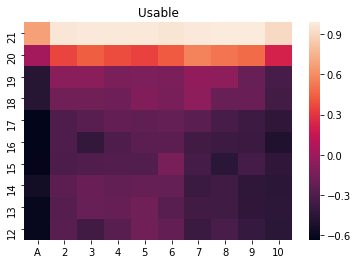

In [65]:
ax = sns.heatmap(mat_usable, yticklabels = [i for i in range(12, 22)] , xticklabels= ['A', 2,3,4,5,6,7,8,9,10 ])
ax.invert_yaxis()
ax.set_title('Usable')
plt.show()

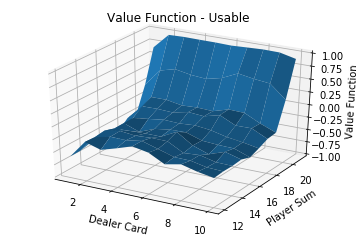

In [66]:
X, Y = np.meshgrid( [1,2,3,4,5,6,7,8,9,10 ], [i for i in range(12, 22)])
Z = mat_usable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
ax.set_zlim(-1, 1)
ax.set_xlabel('Dealer Card')
ax.set_ylabel('Player Sum')
ax.set_zlabel('Value Function')
plt.title('Value Function - Usable')
plt.show()

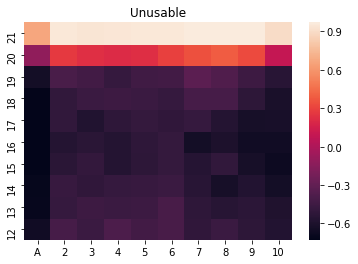

In [67]:
ax = sns.heatmap(mat_unusable, yticklabels = [i for i in range(12, 22)] , xticklabels= ['A', 2,3,4,5,6,7,8,9,10 ])
ax.invert_yaxis()
ax.set_title('Unusable')
plt.show()

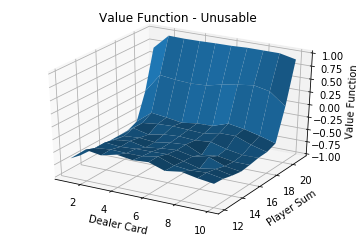

In [68]:
X, Y = np.meshgrid( [1,2,3,4,5,6,7,8,9,10 ], [i for i in range(12, 22)])
Z = mat_unusable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
ax.set_zlim(-1, 1)
ax.set_xlabel('Dealer Card')
ax.set_ylabel('Player Sum')
ax.set_zlabel('Value Function')
plt.title('Value Function - Unusable')
plt.show()

In [69]:
## Figure 2

no_of_states = 200
states = []
for player_sum in range(12, 22):
    for ace in range(0,2):
        for opp_card in range(1, 11):
            this_state = (player_sum, bool(ace), opp_card)
            states.append(this_state)
            
def MC(epoch):
    Q = {}
    counts = {}
    pi = {}
    for i in states:
        pi[i] = 1
        if i[0] == 20 or i[0] == 21:
            pi[i] = 0

    for i in states:
        for j in [0,1]:
            Q[(i,j)] = 0
            counts[(i,j)] = 0
        
    episode_count = 0
    while episode_count < epoch:
        G, state = run_episode(pi)
        processed = {}
        for s in state:
            st, at = s[0], s[1]
            if (st, at) in processed:
                continue
            processed[(st, at)] = True
            counts[(st, at)] += 1
            Q[(st, at)] = Q[(st, at)] + ((G - Q[(st, at)])/counts[(st, at)])
            pi[st] = 1 if Q[(st, 1)] > Q[(st, 0)] else 0
        episode_count += 1
        if episode_count%1000==0:
            print('\rEpisode {}/{}.'.format(episode_count, epoch), end = "")
    return Q, pi

In [70]:
epoch = 500000
Q, pi = MC(epoch)

Episode 500000/500000.

In [71]:
V = {}
for s in states:
    V[s] = max(Q[(s,1)], Q[(s,0)])
    
mat_usable = np.zeros(shape=(10,10))
mat_unusable = np.zeros(shape=(10,10))
p_usable = [[True for i in range(10)] for j in range(11)]
p_unusable = [[True for i in range(10)] for j in range(11)]

for i in range(12,22):
    for j in range(1, 11):
        mat_usable[i-12][j-11] = V[(i,True,j)]
        mat_unusable[i-12][j-11] = V[(i,False,j)]
        p_usable[i-11][j-11] = pi[(i,True,j)]
        p_unusable[i-11][j-11] = pi[(i,False,j)]

Fig 2

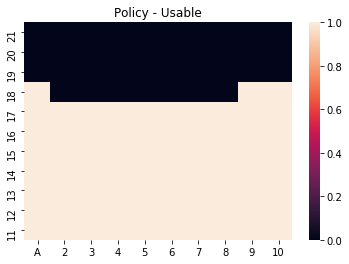

In [72]:
## Optimal Policy with Usable ace

ax = sns.heatmap(p_usable, yticklabels = [i for i in range(11, 22)] , xticklabels= ['A', 2,3,4,5,6,7,8,9,10 ])
ax.invert_yaxis()
ax.set_title('Policy - Usable')
plt.show()

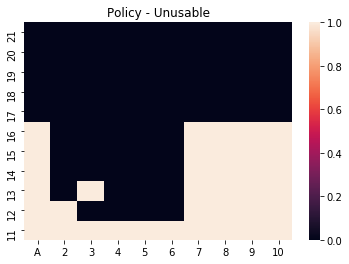

In [73]:
## Optimal Policy with no usable ace

ax = sns.heatmap(p_unusable, yticklabels = [i for i in range(11, 22)] , xticklabels= ['A', 2,3,4,5,6,7,8,9,10 ])
ax.invert_yaxis()
ax.set_title('Policy - Unusable')
plt.show()

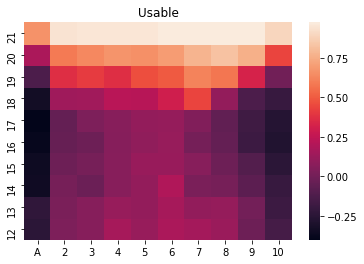

In [74]:
## Optimal Value function with Usable ace

ax = sns.heatmap(mat_usable, yticklabels = [i for i in range(12, 22)] , xticklabels= ['A', 2,3,4,5,6,7,8,9,10 ])
ax.invert_yaxis()
ax.set_title('Usable')
plt.show()

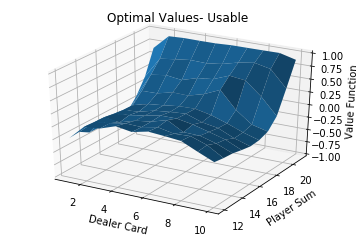

In [75]:
## Optimal Value function with Usable ace

X, Y = np.meshgrid( [1,2,3,4,5,6,7,8,9,10 ], [i for i in range(12, 22)])
Z = mat_usable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
ax.set_zlim(-1, 1)
ax.set_xlabel('Dealer Card')
ax.set_ylabel('Player Sum')
ax.set_zlabel('Value Function')
plt.title('Optimal Values- Usable')
plt.show()

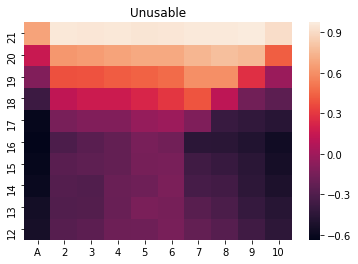

In [76]:
## Optimal Value function with no Usable ace

ax = sns.heatmap(mat_unusable, yticklabels = [i for i in range(12, 22)] , xticklabels= ['A', 2,3,4,5,6,7,8,9,10 ])
ax.invert_yaxis()
ax.set_title('Unusable')
plt.show()

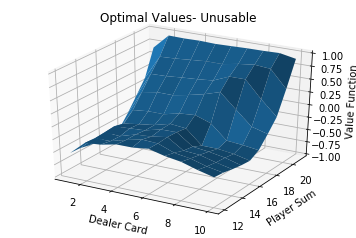

In [77]:
## Optimal Value function with no Usable ace

X, Y = np.meshgrid( [1,2,3,4,5,6,7,8,9,10 ], [i for i in range(12, 22)])
Z = mat_unusable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
ax.set_zlim(-1, 1)
ax.set_xlabel('Dealer Card')
ax.set_ylabel('Player Sum')
ax.set_zlabel('Value Function')
plt.title('Optimal Values- Unusable')
plt.show()

In [57]:
## Figure 3

def get_card():
    r = random.randint(1,13)
    return min(r, 10)
    
## Episode Generation for blackjack for the state (13, 1, A)
def run_episode(pi):
    ## Random Initial States
    
    ## Exploring starts
    p_sum = 13
    ace = 1
    d_card1 = 1
    d_card2 = 1
    
    p = player((p_sum, ace, d_card1))
    d = dealer(d_card1)
    d.add(d_card2)
    
    state = []
    a0 = random.randint(0,1)
    state.append((p.state,a0))
    
    if p.sum == 21 and d.get_sum() == 21:
        return 0, state
    
    if p.sum == 21:
        d.lose = True
        return 1, state
    
    if a0:
        while not p.lose:
            p.add(get_card())
            if p.lose:
                return -1, state
            a = random.randint(0,1)
            state.append((p.state,a))
            if not a:
                break
        if p.lose:
            return -1, state
        
    if p.lose:
        return -1, state
    
    while d.move() and not d.lose:
        d.add(get_card())
        
    if d.lose:
        return 1, state
    if abs(21 - p.sum) < abs(21 - d.get_sum()):
        return 1, state
    elif abs(21 - p.sum) > abs(21 - d.get_sum()):
        return -1, state
    else:
        return 0, state

In [58]:
def ordinary_sampling_mc(epoch):
    Q = {}
    counts = {}
    pi = {}
    for i in states:
        pi[i] = 1
        if i[0] == 20 or i[0] == 21:
            pi[i] = 0

    for i in states:
        for j in [0,1]:
            Q[(i,j)] = random.random()
            counts[(i,j)] = 0
        
    episode_count = 0
    val = np.zeros(shape=(epoch))
    while episode_count < epoch:
        G, state = run_episode(pi)
        processed = {}
        W = 1
        for s in state:
            st, at = s[0], s[1]
            if (st, at) in processed:
                continue
            processed[(st, at)] = True
            counts[(st, at)] += 1
            Q[(st, at)] = (Q[(st, at)]*(counts[(st, at)]-1) + G*W)/counts[(st, at)]
            W = W*2
        val[episode_count] = max(Q[((13, 1, 1), 0)], Q[((13, 1, 1), 1)])
        episode_count += 1
        if episode_count%1000==0:
            print('\rEpisode {}/{}.'.format(episode_count, epoch), end = "")
    return val

In [59]:
def weighted_sampling_mc(epoch):
    Q = {}
    counts = {}
    pi = {}
    for i in states:
        pi[i] = 1
        if i[0] == 20 or i[0] == 21:
            pi[i] = 0

    for i in states:
        for j in [0,1]:
            Q[(i,j)] = random.random()
            counts[(i,j)] = 0
        
    episode_count = 0
    val = np.zeros(shape=(epoch))
    while episode_count < epoch:
        G, state = run_episode(pi)
        processed = {}
        W = 1
        for s in state:
            st, at = s[0], s[1]
            if (st, at) in processed:
                continue
            processed[(st, at)] = True
            counts[(st, at)] += W
            Q[(st, at)] = (Q[(st, at)]*(counts[(st, at)] - W) + W*G)/counts[(st, at)]
            W = W*2
        val[episode_count] = max(Q[((13, 1, 1), 0)], Q[((13, 1, 1), 1)])
        episode_count += 1
        if episode_count%1000==0:
            print('\rEpisode {}/{}.'.format(episode_count, epoch), end = "")
    return val
    

Episode 10000/10000.

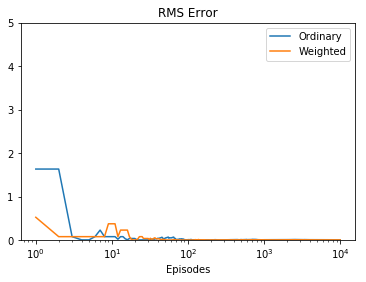

In [60]:
val_avg = ordinary_sampling_mc(10000)
val_weighted = weighted_sampling_mc(10000)

true = -0.27726

val_avg = [(val-true)**2 for val in val_avg][1:]
val_weighted = [(val-true)**2 for val in val_weighted][1:]

x = [i for i in range(1,10000)]
plt.plot(x, val_avg, label = "Ordinary")
plt.plot(x, val_weighted, label = "Weighted")
plt.xlabel('Episodes')
plt.title('RMS Error')
plt.ylim(0, 5)
plt.xscale('log')
plt.legend()
plt.show()

Q6

In [24]:
## Episode Generation for Monte Carlo Control

def episode():
    s = 1
    states = []
    rewards = []
    actions = []
    while s!= 0 and s!= 6:
        a = random.choice([-1,1])
        states.append(s)
        actions.append(a)
        s += a
        if s == 0:
            rewards.append(0)
            break
        elif s == 6:
            rewards.append(1)
            break
        else:
            rewards.append(0)
            
    return states, rewards, actions

In [25]:
## TD

def td(alpha):
    V_s = []
    V = [0.5]*7
    V[0] = 0
    V[6] = 0
    for e in range(101):
        s = 3
        V_s.append(V.copy())
        while s!= 0 and s!= 6:
            
            ## Update after every step
            a = random.choice([-1,1])
            s_dash = s + a
            r = 0
            if s_dash == 6:
                r = 1
            else:
                r = 0
            V[s] = V[s] + (alpha*(r + V[s_dash] - V[s]))
            s = s_dash
    return V_s

In [26]:
V = td(0.1)

In [27]:
true = [1/6, 2/6, 3/6, 4/6, 5/6]

In [28]:
zero = V[0][1:-1]
one = V[1][1:-1]
ten = V[10][1:-1]
hundred = V[100][1:-1]

In [29]:
x = ['A', 'B', 'C', 'D', 'E']

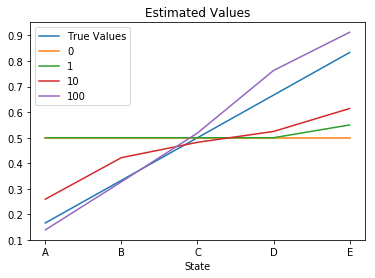

In [30]:
plt.plot(x, true, label = "True Values")
plt.plot(x, zero, label = "0")
plt.plot(x, one, label = "1")
plt.plot(x, ten, label = "10")
plt.plot(x, hundred, label = "100")
plt.xlabel('State')
plt.title('Estimated Values')
plt.legend()
plt.show()

In [31]:
V_1 = td(0.15)
V_2 = td(0.1)
V_3 = td(0.05)

In [32]:
for i in range(101):
    V_1[i] = rms(V_1[i][1:-1], true)
    V_2[i] = rms(V_2[i][1:-1], true)
    V_3[i] = rms(V_3[i][1:-1], true)

In [33]:
## Montre Carlo updates after the entire episode

def monte_carlo(alpha):
    V_s = []
    V = [0.5]*7
    V[0] = 0
    V[6] = 0
    for e in range(101):
        states, rewards, actions = episode()
        N = len(states)
        G = 0
        for t in range(N-1, -1, -1):
            G = G + R[t]
            V[states[i]] = V[states[i]] + (alpha*(G - V[states[i]]))
        V_s.append(V.copy())
    return V_s

In [34]:
V_1_m = td(0.01)
V_2_m = td(0.02)
V_3_m = td(0.03)
V_4_m = td(0.04)
for i in range(101):
    V_1_m[i] = rms(V_1_m[i][1:-1], true)
    V_2_m[i] = rms(V_2_m[i][1:-1], true)
    V_3_m[i] = rms(V_3_m[i][1:-1], true)
    V_4_m[i] = rms(V_4_m[i][1:-1], true)

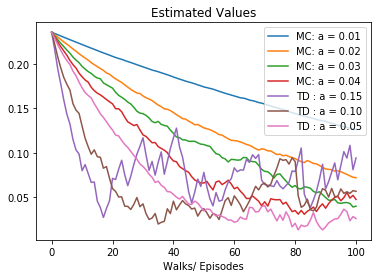

In [35]:
x = [i for i in range(101)]
plt.plot(x, V_1_m, label = "MC: a = 0.01")
plt.plot(x, V_2_m, label = "MC: a = 0.02")
plt.plot(x, V_3_m, label = "MC: a = 0.03")
plt.plot(x, V_4_m, label = "MC: a = 0.04")

x = [i for i in range(101)]
plt.plot(x, V_1, label = "TD : a = 0.15")
plt.plot(x, V_2, label = "TD : a = 0.10")
plt.plot(x, V_3, label = "TD : a = 0.05")

plt.xlabel('Walks/ Episodes')
plt.title('Estimated Values')
plt.legend()
plt.show()

Q7

In [2]:
## Cliff walking

states = []
for i in range(4):
    for j in range(12):
        states.append((i,j))
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
terminal = (3, 11)
init = (3, 0)

In [3]:
def trans(s, a):
    ## Gives the next state given the current state, action
    x, y = s
    if x==3 and 1 <= y <= 10:
        return init, -100
    else:
        dx, dy = a
        x = x + dx
        y = y + dy
        return (x, y), -1
    
def valid(s, a):
    ## Determines whether the action a is valid for the state s.
    x, y = s
    dx, dy = a
    if not (0<=x+dx<=3) or not(0<= y+dy<= 11):
        return False
    else:
        return True

In [4]:
def get_action(Q, e, s):
    ## Epsilon Greedy choice for the current action value function Q, from the state s, with epsilon = e
    a_max = -1
    m = -1e9
    allow = []
    for a in actions:
        if valid(s, a):
            allow.append(a)
            if m < Q[(s,a)]:
                m = Q[(s,a)]
                a_max = a
    
    if random.random() < e:
        return a_max
    else:
        return random.choice(allow)

In [9]:
def q_learning(alpha, e):
    ## Q- Learning Init
    Q = {}
    for s in states:
        for a in actions:
            if valid(s, a):
                Q[(s,a)] = -1
                if s == terminal:
                    Q[(s, a)] = 0
    rewards = []
    
    for ep in range(500):
        sum_of_rewards = 0
        s = init
        while s != terminal:
            a = get_action(Q, e, s)
            s_dash, r = trans(s, a)
            sum_of_rewards += r
            q_dash = -1e9
            
            ## Pick max Q(S', a) from Q
            for a_dash in actions:
                if valid(s_dash, a_dash):
                    q_dash = max(q_dash, Q[(s_dash, a_dash)])
            Q[(s, a)] = Q[(s, a)] + alpha*(r + q_dash - Q[(s, a)])
            s = s_dash
        rewards.append(sum_of_rewards)
    return rewards

In [10]:
def sarsa(alpha, e):
    Q = {}
    for s in states:
        for a in actions:
            if valid(s, a):
                Q[(s,a)] = -1
                if s == terminal:
                    Q[(s, a)] = 0
    rewards = []
    for ep in range(500):
        sum_of_rewards = 0
        s = init
        a = get_action(Q, e, s)
        while s != terminal:
            s_dash, r = trans(s, a)
            sum_of_rewards += r
            a_dash = get_action(Q, e, s_dash)
         
            ## Get action a' from Q using the epsilon greedy policy
            Q[(s, a)] = Q[(s, a)] + alpha*(r + Q[(s_dash, a_dash)] - Q[(s, a)])
            s = s_dash
            a = a_dash
        rewards.append(sum_of_rewards)
    return rewards

In [11]:
rew = q_learning(0.1, 0.1)
rew_s = sarsa(0.1, 0.1)

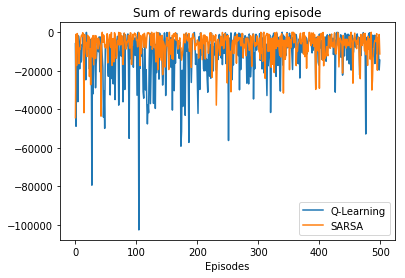

In [12]:
x = [i for i in range(500)]
plt.plot(x, rew, label = "Q-Learning")
plt.plot(x, rew_s, label = "SARSA")

plt.xlabel('Episodes')
plt.title('Sum of rewards during episode')
plt.legend()
plt.show()